In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from model_v0 import DumbDiscretizer, pgmpy_friendly_transformer, CustomDBNInference

c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parameters of the experience 

In [2]:
nb_points = 1000  # nb of time steps in the simulation 
length = 15  # forecast horizon
evidence_date = nb_points - length  # start of test set. 

### Generate Data 

Dans cet exemple simple on suppose avoir trois variables: X1, X2, Y.
1) X1 (resp. X2) à l'instant t+1, ne dépend que de X1 (resp. X2) à l'instant précédent t. 
2) Y à l'instant t ne dépend que de X1 et X2 à l'instant t.  

Concrètement, les données sont simulées de la façon suivante
- X1 est initialisé aléatoirement. Puis si X1 est positif, X1 <-X1 - 0.5 sinon X1 <- X1+2
A chaque étape, un bruit gaussien de variance 0.5 est ajouté. 
- X2 est initialisé aléatoirement. Puis si X2 est positif, X1 <-X1 - 2. sinon X1 <- X1+0.5
A chaque étape, un bruit gaussien de variance 0.5 est ajouté. 
- Y est la somme de X1 et X2, pas de bruit gaussien pour Y. 


In [3]:
def generate_data(nb):
    """
    """
    # generate sinusoidal data
    X1 = np.random.normal(0, 0.25, size=nb)
    X2 = np.random.normal(0, 0.25, size=nb)
    Y = np.zeros(nb, dtype=np.float64)

    # initialization (t=0)
    Y[0] = .5 * (X1[0]+X2[0])

    #create dataset 
    for i in range(1, nb):
        
        if X1[i-1] >= 0:
            X1[i] += X1[i-1] - .5
        else: X1[i] += X1[i-1] + 2.

        if X2[i-1] >= 0:
            X2[i] += X2[i-1] - 2.
        else: X2[i] += X2[i-1] + .5

        Y[i] += .5 * (X1[i]+X2[i])

    data = {
        "X1": X1, 
        "X2": X2, 
        "Y": Y
    }

    return data 

### Visualize data 

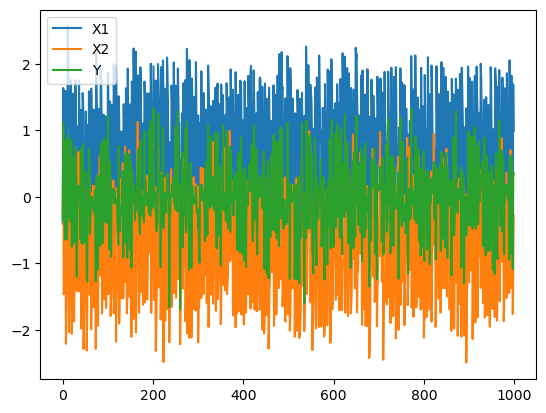

In [4]:
# random sampling
data = generate_data(nb_points)

# generate plots
for var in data.keys():
    plt.plot(np.arange(nb_points), data.get(var), label=var)

plt.legend()  # add legend

### Prepare data 

Convert data to dataframe 

In [5]:
# initialization of the dataframe 
my_data = pd.DataFrame()

# create column, one column is one variable time series
for var, seq in data.items():
    my_data[var] = seq

my_data.head()  # observe first points

,X1,X2,Y
0,-0.401336,-0.287995,-0.344666
1,1.638849,0.602734,1.120792
2,1.107222,-1.465581,-0.179180
3,0.818632,-1.414581,-0.297975
4,0.230160,-1.017240,-0.393540


Discretization 

In [6]:
nb_classes = {  # nb of classes for each variable
    "X1": 10,  
    "X2": 10, 
    "Y": 5
}

# use dumb discretizer method. 
discretizer = DumbDiscretizer(my_data, nb_classes=nb_classes)

# save a discretized version of the dataframe
my_data_index = discretizer.df

Create pgmpy friendly dataframe 

In [7]:
# tf the dataframe into a version pgmpy can handle
my_data_index_pgmpy = pgmpy_friendly_transformer(my_data_index, sliding_window=2)

### Model 

Create the strcuture of the probabilistic graphical model

In [8]:
# build model 
dbn = DBN(
    [
        (("X1", 0), ("Y", 0)),
        (("X2", 0), ("Y", 0)),
        (('X1', 0), ("X1", 1)),
        (('X2', 0), ("X2", 1)),
    ]
)

In [9]:
dbn.fit(my_data_index_pgmpy.iloc[:-5, :])

In [10]:
message = """
Note that if (X1, 0) and (X1, 1) don't have the same nb of values, inference will not work. \n
This can happen if an extremum value taken by the variable is obtained at the very first \n
or very last time step. 
"""

print(message)

my_data_index_pgmpy.nunique()


Note that if (X1, 0) and (X1, 1) don't have the same nb of values, inference will not work. 

This can happen if an extremum value taken by the variable is obtained at the very first 

or very last time step. 



(X1, 0)    11
(X2, 0)    11
(Y, 0)      6
(X1, 1)    11
(X2, 1)    11
(Y, 1)      6
dtype: int64

### Forecasting with Discretized Dynamic Bayesian network 

In [11]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

# provide evidence
evidence_date = nb_points - length
evidence = {
    ("X1", 0): my_data.loc[evidence_date, "X1"], 
    ("X2", 0): my_data.loc[evidence_date, "X2"], 
}

print("Evidence: ", evidence, "\n")

# now make a pred of Y at time t (now) till time t+14
pred_seq = inference.make_pred("Y",
                               forecast_step=length, 
                               evidence=evidence, 
                               method="PM", 
                               verbose=False)

# get actual values model should have predicted 
actual_seq =  my_data.loc[evidence_date:, "Y"].to_list()

print("Actual seq: ", actual_seq)
print("Pred seq: ", pred_seq)

Evidence:  {('X1', 0): 1.3518163362281803, ('X2', 0): -1.2482349173158631} 

Actual seq:  [0.0517907094561586, 0.12426225775942035, -0.05066166722823229, 0.13423972180867996, -0.9496856267811588, 0.5734951020323017, 0.5336245250650773, 0.6251536762030423, -0.8598784069754122, 0.5876969690195795, 0.34822870961004543, 0.27981821174191235, -1.0889695917185385, 0.2890742170509698, 0.35664703696498173]
Pred seq:  [0.03636271940749128, -0.035238358834371125, -0.034006807143141096, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764, 0.0009607121914482764]


c:\Users\victo\anaconda3\envs\TimeSeries\Lib\site-packages\pgmpy\factors\discrete\DiscreteFactor.py:796: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi1.values


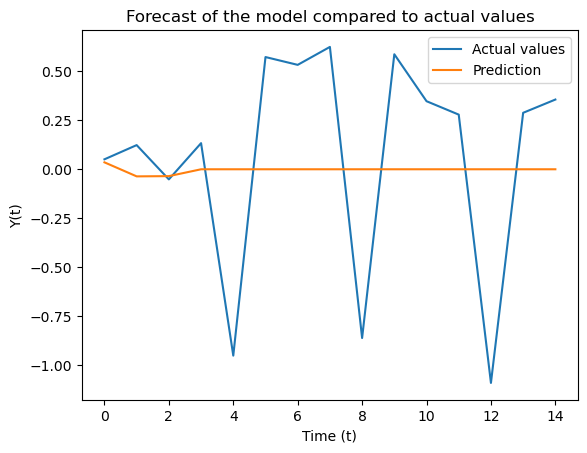

In [12]:
# get sequences
whole_seq = my_data.loc[evidence_date:, "Y"]
all_pred_seq = np.array(pred_seq) 

# plot sequence on a same plot 
plt.plot(np.arange(length), whole_seq, label="Actual values")
plt.plot(np.arange(length), all_pred_seq, label="Prediction")

plt.title("Forecast of the model compared to actual values")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()

Nous pouvons observer sur ce graph que le modèle prédit une valeur cohérente à très court terme mais tombe rapidement dans la prédiction d'une forme de moyenne. 

En prenant un peu de recul, nous pouvions nous attendre à ce genre de résultat. Avec la discrétisation, plus l'incertitude devient grand, plus la prédiction s'étale entre les différentes classes ce qui favorise grandement les valeurs moyennes. Ainsi, dans les zones d'incertitudes élevées, la moyenne est une forme de prédiction qui minimise son risque de se tromper. 

Cela doit remettre en question la décision de discrétiser de cette façon. En effet, en perdant toute relation d'ordre, on favorise une moyenne. D'autres nouvelles méthodes pourraient être implémentées. 

### Les scénrios avec le Discretized Dynamic Bayesian Network. 

Une force de ce modèle déjà identifée est la création des scénarios. En d'autres termes, en lui donnant les valeurs futures d'une variable (par exemple X1), nous pourrions nous intéresser aux conséquences sur la variable Y d'un tel scénario. 

In [13]:
# creation of different scenarios 
scenario1 = {("X1", i): my_data.loc[evidence_date+i, "X1"]
            for i in range(1, length)}
scenario2 = {("X2", i): my_data.loc[evidence_date+i, "X2"]
            for i in range(1, length)}

Vu la simplicité du problème, nous nous intéressons à deux types de scnéarios ici. Si le modèle connait les valeurs futures de X1, quelles seraient les valeurs prises par Y. De la même manière, un scénario de X2, quels seraient les conséquences sur Y.

In [14]:
# use custom inference for model test
inference = CustomDBNInference(dbn, discretizer)

# provide evidence
evidence = {
    ("X1", 0): my_data.loc[evidence_date, "X1"], 
    ("X2", 0): my_data.loc[evidence_date, "X2"], 
}
evidence.update(scenario1)  # create scenario 1 from date t 

# infrence of scenario 1
pred_seq = inference.make_pred("Y",  # name of the variable to infer
                               forecast_step=length, 
                               evidence=evidence, 
                               method="PM", 
                               verbose=False)

# get the answer to the scenario question
actual_seq =  my_data.loc[evidence_date:, "Y"].to_list()

print("Actual seq: ", actual_seq)
print("Pred seq: ", pred_seq)

Actual seq:  [0.0517907094561586, 0.12426225775942035, -0.05066166722823229, 0.13423972180867996, -0.9496856267811588, 0.5734951020323017, 0.5336245250650773, 0.6251536762030423, -0.8598784069754122, 0.5876969690195795, 0.34822870961004543, 0.27981821174191235, -1.0889695917185385, 0.2890742170509698, 0.35664703696498173]
Pred seq:  [0.03636271940749128, 0.07934626029736182, 0.1177610126357953, -0.2919276266526589, -0.6301012934326076, 0.5765624129326996, 0.26256882408890553, -0.10775251552556254, -0.48828281521416483, 0.4650886429283077, 0.06359068424246223, -0.10775251552556254, -0.6301012934326078, 0.46508864292830776, 0.06359068424246216]


MAE:  0.27


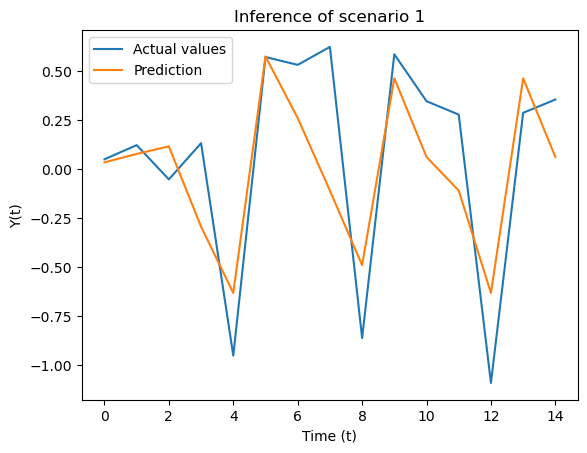

In [15]:
# get sequences for comparison
whole_seq = my_data.loc[evidence_date:, "Y"]
all_pred_seq = np.array(pred_seq) 
mae = np.mean(np.abs(whole_seq - all_pred_seq))
print("MAE: ", round(mae, 2))

# get curves on a sampe plot
plt.plot(np.arange(length), whole_seq, label="Actual values")
plt.plot(np.arange(length), all_pred_seq, label="Prediction")

plt.title("Inference of scenario 1")
plt.xlabel("Time (t)")
plt.ylabel("Y(t)")
plt.legend()
plt.show()

On peut voir qu'à la donnée d'un scénario, les prédictions sont correctes. Le modèle est bien meilleur que pour une prédiction long terme. 
Il semble évident que le modèle sait capturer les corrélation qui existent entre les variables mais a du mal à prédire en partant de rien. Sans doute de cette idée que sont nés les modèles hybrides qui permettent de mélanger ML et les modèles graphiques probabilistes. 